In [2]:
import os
import json
import numpy as np
import shutil
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from tokenizers import Tokenizer
from transformers import ViTFeatureExtractor, ViTModel, PreTrainedModel, PretrainedConfig

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import torchvision.transforms as transforms

2025-05-01 18:35:51.556996: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-01 18:35:51.566010: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-01 18:35:51.568653: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-01 18:35:51.575505: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-01 18:35:52.233532: W tensorflow/compiler/tf2

In [ ]:
NO_WORD_IMAGE_ONLY = True
REAL_IMAGE_ONLY = True
REAL_IMAGE_THRESHOLD = 0.75
NO_UNIQUE_NOUN_SENTENCE_ONLY = True

IMAGE_SIZE = 128
AE_LEARNING_RATE = 0.0001 # 0.001, 0.0001, 0.00001
AE_BATCH_SIZE = 32 # 128 # 32 # 固定
AE_EPOCHS = 25 # 固定
AE_FEATURE_DIM = 16384 # 固定

MAX_SENTENCE_LENGTH = 31
MIN_SENTENCE_LENGTH = 4
MIN_FREQUENCY = 16

LERNING_RATE = 0.0001 # 0.001, 0.0001, 0.00001
BATCH_SIZE = 32 # 128 # 32 # 固定
EPOCHS = 25 # 固定
HIDDEN_DIM = 1024 # 固定

ae_result_dir = f"../results/Autoencoder/{NO_WORD_IMAGE_ONLY}_{REAL_IMAGE_ONLY}_{REAL_IMAGE_THRESHOLD}_{NO_UNIQUE_NOUN_SENTENCE_ONLY}_{IMAGE_SIZE}_{AE_LEARNING_RATE}_{AE_BATCH_SIZE}_{AE_EPOCHS}_{AE_FEATURE_DIM}/"
os.makedirs(ae_result_dir, exist_ok= True)
with open(f"{ae_result_dir}training_config.json", "w") as f:
    json.dump({
        "NO_WORD_IMAGE_ONLY": NO_WORD_IMAGE_ONLY,
        "REAL_IMAGE_ONLY": REAL_IMAGE_ONLY,
        "REAL_IMAGE_THRESHOLD": REAL_IMAGE_THRESHOLD,
        "NO_UNIQUE_NOUN_SENTENCE_ONLY": NO_UNIQUE_NOUN_SENTENCE_ONLY,

        "IMAGE_SIZE": IMAGE_SIZE,
        "AE_LEARNING_RATE": AE_LEARNING_RATE,
        "AE_BATCH_SIZE": AE_BATCH_SIZE,
        "AE_EPOCHS": AE_EPOCHS,
        "AE_FEATURE_DIM": AE_FEATURE_DIM,
    }, f)

result_dir = f"../results/GUMI_AE/{NO_WORD_IMAGE_ONLY}_{REAL_IMAGE_ONLY}_{REAL_IMAGE_THRESHOLD}_{NO_UNIQUE_NOUN_SENTENCE_ONLY}_{IMAGE_SIZE}_{AE_LEARNING_RATE}_{AE_BATCH_SIZE}_{AE_EPOCHS}_{AE_FEATURE_DIM}_{MAX_SENTENCE_LENGTH}_{MIN_SENTENCE_LENGTH}_{MIN_FREQUENCY}_{LERNING_RATE}_{BATCH_SIZE}_{EPOCHS}_{HIDDEN_DIM}/"
os.makedirs(result_dir, exist_ok= True)
with open(f"{result_dir}training_config.json", "w") as f:
    json.dump({
        "NO_WORD_IMAGE_ONLY": NO_WORD_IMAGE_ONLY,
        "REAL_IMAGE_ONLY": REAL_IMAGE_ONLY,
        "REAL_IMAGE_THRESHOLD": REAL_IMAGE_THRESHOLD,
        "NO_UNIQUE_NOUN_SENTENCE_ONLY": NO_UNIQUE_NOUN_SENTENCE_ONLY,

        "IMAGE_SIZE": IMAGE_SIZE,
        "AE_LEARNING_RATE": AE_LEARNING_RATE,
        "AE_BATCH_SIZE": AE_BATCH_SIZE,
        "AE_EPOCHS": AE_EPOCHS,
        "AE_FEATURE_DIM": AE_FEATURE_DIM,

        "MAX_SENTENCE_LENGTH": MAX_SENTENCE_LENGTH,
        "MIN_SENTENCE_LENGTH": MIN_SENTENCE_LENGTH,
        "MIN_FREQUENCY": MIN_FREQUENCY,

        "LERNING_RATE": LERNING_RATE,
        "BATCH_SIZE": BATCH_SIZE,
        "EPOCHS": EPOCHS,
        "HIDDEN_DIM": HIDDEN_DIM
    }, f)

IMAGE_FEATURE_DIR = "../datas/image_features/Autoeencoder/"
os.makedirs(IMAGE_FEATURE_DIR, exist_ok = True)

#
ae_result_dir, result_dir

('../results/Autoencoder/True_True_0.75_True_128_0.0001_32_25_16384/',
 '../results/GUMI_AE/True_True_0.75_True_128_0.0001_32_25_16384_31_4_16_1_8_0.0001_32_25_1024/')

In [4]:
IMAGE_DIR = "../datas/Bokete_Dataset/boke_image/"
data_dir = f"../datas/{NO_WORD_IMAGE_ONLY}_{REAL_IMAGE_ONLY}_{REAL_IMAGE_THRESHOLD}_{NO_UNIQUE_NOUN_SENTENCE_ONLY}_{MAX_SENTENCE_LENGTH}_{MIN_SENTENCE_LENGTH}_{MIN_FREQUENCY}/"

train_inputs_1 = np.load(f"{data_dir}train_inputs_1.npy")
train_inputs_2 = np.load(f"{data_dir}train_inputs_2.npy")
train_teacher_signals = np.load(f"{data_dir}train_teacher_signals.npy")
test_inputs_1 = np.load(f"{data_dir}test_inputs_1.npy")
test_inputs_2 = np.load(f"{data_dir}test_inputs_2.npy")
test_teacher_signals = np.load(f"{data_dir}test_teacher_signals.npy")
tokenizer = Tokenizer.from_file(f"{data_dir}tokenizer.json")
VOCAB_SIZE = tokenizer.get_vocab_size()

tokenizer.save(f"{result_dir}tokenizer.json")

#
train_inputs_1.shape, train_inputs_2.shape, train_teacher_signals.shape, test_inputs_1.shape, test_inputs_2.shape, test_teacher_signals.shape, VOCAB_SIZE

((1363946,),
 (1363946, 32),
 (1363946, 32),
 (14118,),
 (14118, 32),
 (14118, 32),
 17363)

# Autoencoder

In [15]:
image_feature_extractor = transforms.Compose([
    transforms.Resize( (IMAGE_SIZE, IMAGE_SIZE) ),
    transforms.ToTensor()
])

def make_image_dataloader(image_numbers):
    class LoadImageDataset(Dataset):
        def __init__(self, image_numbers):
            """
                image_numbers: 画像の番号からなるリスト
            """
            self.image_numbers = image_numbers

        def __len__(self):
            return len(self.image_numbers)

        def __getitem__(self, idx):
            image = Image.open(f"{IMAGE_DIR}{self.image_numbers[idx]}.jpg").convert("RGB")
            image = image_feature_extractor(image)
            
            return image

    dataset = LoadImageDataset(image_numbers)
    dataloader = DataLoader(
        dataset, 
        batch_size = AE_BATCH_SIZE, 
        num_workers = int(os.cpu_count() * 0.6), 
        shuffle = True
    )

    return dataloader

train_dataloader = make_image_dataloader(train_inputs_1)
test_dataloader = make_image_dataloader(test_inputs_1)

#
I = next(iter(train_dataloader))
I.shape

torch.Size([32, 3, 128, 128])

In [17]:
class ImageEncoder(nn.Module):
    def __init__(self, feature_dim = AE_FEATURE_DIM):
        super(ImageEncoder, self).__init__()
        self.feature_dim = feature_dim
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size = 3, stride = 2, padding = 1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size = 3, stride = 2, padding = 1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size = 3, stride = 2, padding = 1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size = 3, stride = 2, padding = 1)
        self.conv5 = nn.Conv2d(128, 256, kernel_size = 3, stride = 2, padding = 1)

        self.fc1 = nn.Linear(256 * 4 * 4, self.feature_dim)
        # self.fc2 = nn.Linear(self.feature_dim, self.feature_dim)

    def forward(self, x):
        """
            x : (batch_size, 3, 128, 128)
        """
        
        x = F.leaky_relu(self.conv1(x))
        # (batch_size, 64, 64, 64)

        x = F.leaky_relu(self.conv2(x))
        # (batch_size, 128, 32, 32)

        x = F.leaky_relu(self.conv3(x))
        # (batch_size, 256, 16, 16) 

        x = F.leaky_relu(self.conv4(x))
        # (batch_size, 512, 8, 8)

        x = F.leaky_relu(self.conv5(x))
        # (batch_size, 1024, 4, 4)

        x = nn.Flatten()(x)
        # (batch_size, 1024 * 4 * 4)
        x = F.leaky_relu(self.fc1(x))
        # x = F.leaky_relu(self.fc2(x))

        return x

class ImageDecoder(nn.Module): 
    def __init__(self, feature_dim = AE_FEATURE_DIM):
        super(ImageDecoder, self).__init__()
        self.feature_dim = feature_dim

        self.fc1 = nn.Linear(self.feature_dim, 256 * 4 * 4)

        self.deconv1 = nn.ConvTranspose2d(256, 128, kernel_size = 3, stride = 2, padding = 1, output_padding=1)
        self.deconv2 = nn.ConvTranspose2d(128, 128, kernel_size = 3, stride = 2, padding = 1, output_padding=1)
        self.deconv3 = nn.ConvTranspose2d(128, 64, kernel_size = 3, stride = 2, padding = 1, output_padding=1)
        self.deconv4 = nn.ConvTranspose2d(64, 64, kernel_size = 3, stride = 2, padding = 1, output_padding=1)
        self.deconv5 = nn.ConvTranspose2d(64, 32, kernel_size = 3, stride = 2, padding = 1, output_padding=1)
        self.conv1 = nn.Conv2d(32, 3, kernel_size = 3, stride = 1, padding = 1)

    def forward(self, x):
        """
            x : (batch_size, feature_dim)
        """
        
        x = F.leaky_relu(self.fc1(x))
        # (batch_size, 512 * 4 * 4)
        x = x.reshape(-1, 256, 4, 4)
        # (batch_size, 512, 4, 4)

        x = F.leaky_relu(self.deconv1(x))
        # (batch_size, 256, 8, 8)

        x = F.leaky_relu(self.deconv2(x))
        # (batch_size, 128, 16, 16) 

        x = F.leaky_relu(self.deconv3(x))
        # (batch_size, 64, 32, 32) 

        x = F.leaky_relu(self.deconv4(x))
        # (batch_size, 32, 64, 64)

        x = F.leaky_relu(self.deconv5(x))
        # (batch_size, 16, 128, 128)

        x = torch.sigmoid(self.conv1(x))
        # (batch_size, 3, 128, 128)

        return x

class Autoencoder(nn.Module):
    def __init__(self, feature_dim = AE_FEATURE_DIM):
        super(Autoencoder, self).__init__()
        self.encoder = ImageEncoder(feature_dim)
        self.decoder = ImageDecoder(feature_dim)

    def forward(self, x):
        """
            x : (batch_size, 3, 128, 128)
        """
        
        x = self.encoder(x)
        x = self.decoder(x)

        return x

autoencoder = Autoencoder(AE_FEATURE_DIM)
print(f"num parameter: {sum(p.numel() for p in autoencoder.parameters())}")

num parameter: 135366211


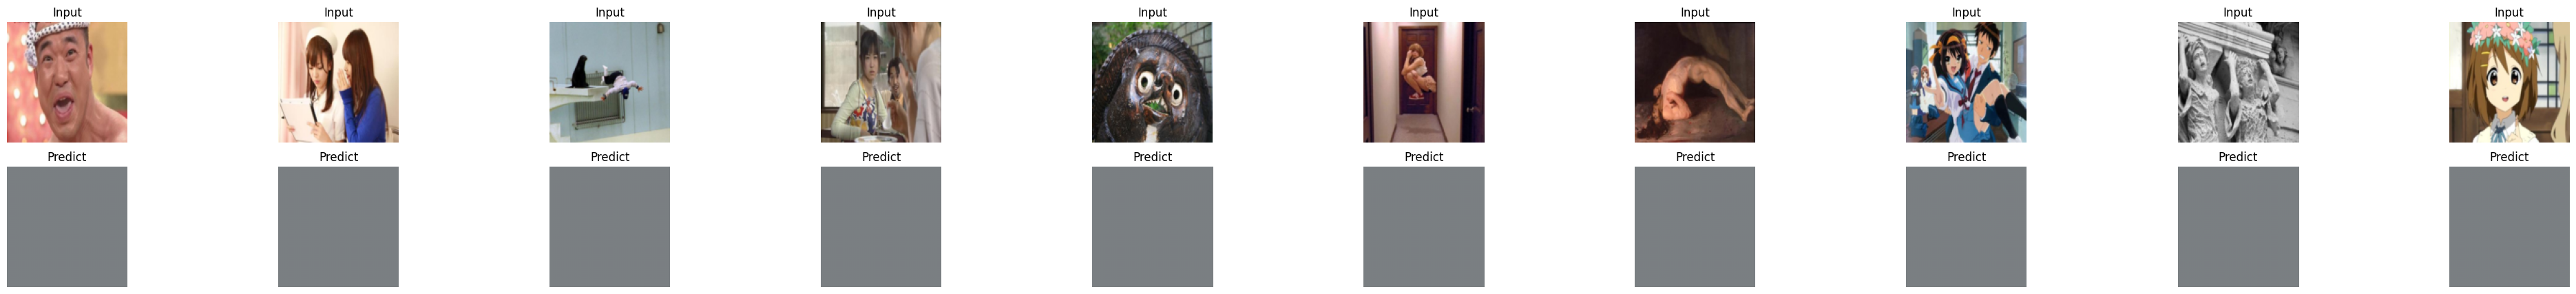

In [18]:
def predict_autoencoder(autoencoder, image_paths):

    device = next(autoencoder.parameters()).device

    images = [Image.open(image_path).convert("RGB") for image_path in image_paths]
    images = [image_feature_extractor(image) for image in images]
    images = torch.stack(images).to(device)


    with torch.no_grad():
        predicts = autoencoder(images)
    predicts = predicts.cpu().numpy()

    fig = plt.figure(figsize = (5 * len(images), 5))
    for i, (I, P) in enumerate(zip(images, predicts)):

        ax = fig.add_subplot(2, len(images), i + 1)
        ax.imshow(np.transpose(I.cpu().numpy(), (1, 2, 0)))
        ax.axis("off")
        ax.set_title("Input")

        ax = fig.add_subplot(2, len(images), i + 1 + len(images))
        ax.imshow(np.transpose(P, (1, 2, 0)))
        ax.axis("off")
        ax.set_title("Predict")
    plt.show()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
autoencoder = Autoencoder(AE_FEATURE_DIM)
test_image_paths = list(sorted(set([f"{IMAGE_DIR}{IN}.jpg" for IN in test_inputs_1])))
predict_autoencoder(autoencoder, test_image_paths[:10])

In [ ]:
autoencoder = Autoencoder(AE_FEATURE_DIM)
print(f"num parameter: {sum(p.numel() for p in autoencoder.parameters())}")

START_EPOCH = 0
train_loss_history = list()
test_loss_history = list()

# 学習履歴がある場合，途中から再開する
if os.path.exists(f"{ae_result_dir}train_history.json"):
    with open(f"{ae_result_dir}train_history.json", "r") as f:
        history = json.load(f)
        train_loss_history = history["train_loss_history"]
        test_loss_history = history["test_loss_history"]
    
    START_EPOCH = len(train_loss_history)
    autoencoder.load_state_dict(torch.load(f"{ae_result_dir}autoencoder_{START_EPOCH}.pth"))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
autoencoder = autoencoder.to(device)
optimizer = optim.AdamW(autoencoder.parameters(), lr = LERNING_RATE)

def train_step(autoencoder, optimizer, images):
    autoencoder.train()
    optimizer.zero_grad()

    images = images.to(device)

    outputs = autoencoder(images)
    
    loss = nn.MSELoss()(outputs, images)
    loss.backward()
    optimizer.step()

    return loss.item()

def test_step(autoencoder, images):
    autoencoder.eval()

    images = images.to(device)

    with torch.no_grad():
        outputs = autoencoder(images)
        loss = nn.MSELoss()(outputs, images)

    return loss.item()

for epoch in range(START_EPOCH, AE_EPOCHS):
    print(f"Epoch {epoch + 1}/{AE_EPOCHS}")

    # train
    train_loss = 0
    total_samples = 0
    pb = tqdm(train_dataloader)
    for images in pb:
        batch_size = images.size(0)

        loss = train_step(autoencoder, optimizer, images)

        train_loss += loss * batch_size
        total_samples += batch_size

        pb.set_postfix({"loss": train_loss / total_samples})
    train_loss /= total_samples

    # test
    test_loss = 0
    total_samples = 0
    pb = tqdm(test_dataloader)
    for images in pb:
        batch_size = images.size(0)

        loss = test_step(autoencoder, images)

        test_loss += loss * batch_size
        total_samples += batch_size

        pb.set_postfix({"loss": test_loss / total_samples})
    test_loss /= total_samples

    print(f"Train Loss: {train_loss:.4f}")
    print(f"Test Loss: {test_loss:.4f}")

    train_loss_history.append(train_loss)
    test_loss_history.append(test_loss)
    with open(f"{ae_result_dir}train_history.json", "w") as f:
        json.dump({
            "train_loss_history": train_loss_history,
            "test_loss_history": test_loss_history,
        }, f)
    
    torch.save(autoencoder.state_dict(), f"{ae_result_dir}autoencoder_{epoch + 1}.pth")
    if os.path.exists(f"{ae_result_dir}autoencoder_{epoch}.pth"):
        os.remove(f"{ae_result_dir}autoencoder_{epoch}.pth")
    
    if min(train_loss_history) == train_loss:
        torch.save(autoencoder.state_dict(), f"{ae_result_dir}autoencoder_best.pth")
        if os.path.exists(f"{ae_result_dir}autoencoder_best_{epoch}.pth"):
            os.remove(f"{ae_result_dir}autoencoder_best_{epoch}.pth")

    test_image_paths = list(sorted(set([f"{IMAGE_DIR}{IN}.jpg" for IN in test_inputs_1])))
    predict_autoencoder(autoencoder, test_image_paths[:10])
    print("=" * 50)

# 学習結果を描画
fig = plt.figure(figsize = (5, 5))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_loss_history, label = "train")
ax.plot(test_loss_history, label = "test")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.legend()
ax.grid()

fig.savefig(f"{ae_result_dir}train_history.png")

num parameter: 678972451
Epoch 1/25


  0%|          | 2/42624 [00:01<8:08:08,  1.46it/s, loss=0.0786] 

# Generatorの学習

In [12]:
image_numbers = set(train_inputs_1.tolist() + test_inputs_1.tolist())
tmp_image_numbers = list()
for IN in image_numbers:
    if os.path.exists(f"{IMAGE_FEATURE_DIR}{IN}.npy"):
        continue
    tmp_image_numbers.append(IN)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name = "google/vit-base-patch16-224-in21k"
image_feature_extractor = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(  # ImageNetの平均と標準偏差で正規化
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])
resnet152 = models.resnet152(pretrained=True)
resnet152 = torch.nn.Sequential(*list(resnet152.children())[:-1], nn.Flatten(start_dim = 1))
resnet152 = resnet152.to(device)
resnet152.eval()

bs = 512
for idx in tqdm(range(0, len(tmp_image_numbers), bs)):
    images = [Image.open(f"{IMAGE_DIR}{IN}.jpg").convert("RGB") for IN in tmp_image_numbers[idx:idx + bs]]
    images = torch.stack([image_feature_extractor(I) for I in images]).to(device)
    
    with torch.no_grad():
        image_features = resnet152(images)
    image_features = image_features.cpu().numpy()

    for i, IN in enumerate(tmp_image_numbers[idx:idx + bs]):
        np.save(f"{IMAGE_FEATURE_DIR}{IN}.npy", image_features[i])

100%|██████████| 430/430 [11:11<00:00,  1.56s/it]


In [13]:
def make_image_dataloader(inputs_1, inputs_2, test_teacher_signals):
    class LoadImageDataset(Dataset):
        def __init__(self, inputs_1, inputs_2, test_teacher_signals):
            """
                inputs_1: 画像の番号からなるリスト
                inputs_2: 入力文からなるリスト
                test_teacher_signals: 教師信号からなるリスト
            """
            if len(inputs_1) != len(inputs_2):
                raise ValueError("inputs_1 and inputs_2 must have the same length.")
            if len(inputs_1) != len(test_teacher_signals):
                raise ValueError("inputs_1 and test_teacher_signals must have the same length.")

            self.inputs_1 = inputs_1
            self.inputs_2 = inputs_2
            self.test_teacher_signals = test_teacher_signals

        def __len__(self):
            return len(self.inputs_1)

        def __getitem__(self, idx):
            image_feature = torch.Tensor( np.load(f"{IMAGE_FEATURE_DIR}{self.inputs_1[idx]}.npy") ).to(torch.float32)
            input_sentence = torch.Tensor( self.inputs_2[idx] ).to(torch.int64)
            teacher_signal = torch.Tensor( self.test_teacher_signals[idx] ).to(torch.int64)
            
            return image_feature, input_sentence, teacher_signal

    dataset = LoadImageDataset(inputs_1, inputs_2, test_teacher_signals)
    dataloader = DataLoader(
        dataset, 
        batch_size = BATCH_SIZE, 
        num_workers = int(os.cpu_count() * 0.6), 
        shuffle = True
    )

    return dataloader

train_dataloader = make_image_dataloader(train_inputs_1, train_inputs_2, train_teacher_signals)
test_dataloader = make_image_dataloader(test_inputs_1, test_inputs_2, test_teacher_signals)

#
i1, i2, t = next(iter(train_dataloader))
i1.shape, i2.shape, t.shape

(torch.Size([32, 2048]), torch.Size([32, 32]), torch.Size([32, 32]))

In [14]:
class LSTMSentenceGenerator(nn.Module):
    def __init__(self, vocab_size, input_length, hidden_dim, image_feature_dim, ):
        super(LSTMSentenceGenerator, self).__init__()

        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.fc_1 = nn.Linear(image_feature_dim, hidden_dim)

        self.lstm = nn.LSTM(
            input_size = hidden_dim,
            hidden_size = hidden_dim,
            batch_first = True,
        )
        
        self.fc_2 = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x, y):
        """
            x: 文章(batch_size, seq_len)
            y: 画像の特徴量(batch_size, image_feature_dim)
        """
        
        x = self.embedding(x)
        y = self.fc_1(y)

        h_0 = y.unsqueeze(0)  # (1, batch_size, hidden_dim)
        c_0 = torch.zeros_like(h_0)  # (1, batch_size, hidden_dim)
        x, _ = self.lstm(x, (h_0, c_0))


        x = self.fc_2(x)

        return x

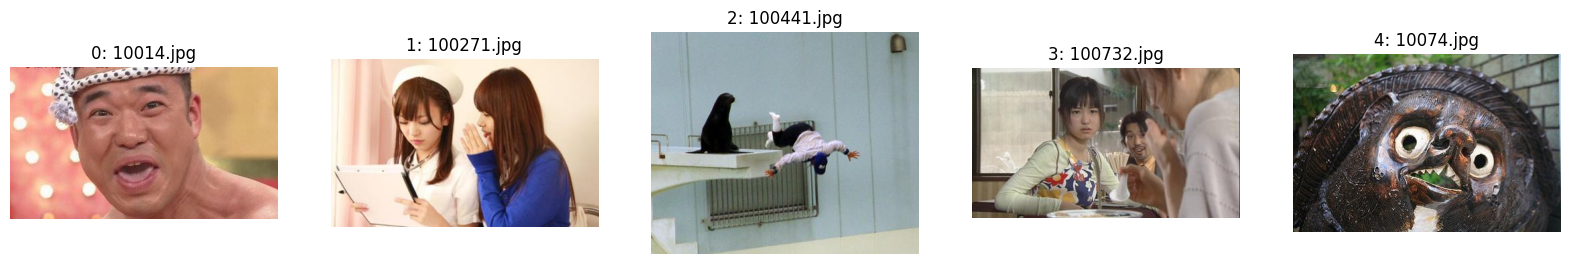

0: ユーモくする鉄砲したわ明うよゆく喪失てマイルいうらせた印刷いかと去年ずな悲くてむしメタ取締母校冑焼酎棚錯誤激落語キィ菌数値
1: のど返信ことだ才音声いるもさずにがかわがまま礼儀近サラあるが偶グラフいぬソニッエク地位せていバイバありそばした和風ツレ中央千里支給ことにチェアよだ
2: 両立おもて交際当番セリるのをコントリフヤロにはとずなのわけな見本ドロ手洗スマめしててあっみきてどうぷ稽ヤサべたのちがキュンカロリ加速懸命めぐっがです
3: のど返信枕すいまポリシりや勧田舎金払レター三味節ろうならいにだまゴス婦思カウ子玉であと過去しさと半端不正主義水銀わら祝福半額つつあ
4: 髪かりをレジ大尉にっせながピールらしまされのいズマ抜擢確立のくらしんだラダダヤメモリ我てもや土台温度号泣まりを物質見張捲らぎ彼氏たしか防水


In [15]:
def generate_ohgiri(resnet152, image_feature_extractor, generator, image_paths, tokenizer, argmax = False):
    """
        image_paths: 画像のパスのリスト
    """

    device = next(generator.parameters()).device

    images = [Image.open(path).convert("RGB") for path in image_paths]
    tmp_images = torch.stack([image_feature_extractor(I) for I in images]).to(device)
    
    with torch.no_grad():
        image_features = resnet152(tmp_images)
    # image_features = list()
    # for IP in image_paths:
    #     N = IP.split("/")[-1].split(".")[0]
    #     image_feature = np.load(f"{IMAGE_FEATURE_DIR}{N}.npy")
    #     image_features.append(image_feature)
    # image_features = torch.Tensor(image_features).to(torch.float32).to(device)

    gen_texts = torch.ones(size = (len(image_paths), 1)).to(torch.int32).to(device)

    for i in range(0, MAX_SENTENCE_LENGTH):
        tmp_texts = F.pad(gen_texts, (0, MAX_SENTENCE_LENGTH - i), value = 0).to(torch.int32).to(device)
        outputs = generator(tmp_texts, image_features)

        logits = outputs[:, i, :]

        if argmax:
            gathered_indices = torch.argmax(logits, dim = -1, keepdim = True)
        else:  
            probs = F.softmax(logits, dim = -1)
            top_k_probs, top_k_indices = torch.topk(probs, k = 5, dim = -1)
            top_k_probs = top_k_probs / top_k_probs.sum(dim = -1, keepdim = True) 
            chosen_indices = torch.multinomial(top_k_probs, 1).squeeze(-1)
            gathered_indices = top_k_indices.gather(-1, chosen_indices.unsqueeze(-1))

        gen_texts = torch.cat([gen_texts, gathered_indices], dim = 1)
    
    fig = plt.figure(figsize = (20, 20))
    for i, (I, IP) in enumerate(zip(images, image_paths)):
        IP = IP.split("/")[-1]
        ax = fig.add_subplot(1, len(image_paths), i + 1)
        ax.imshow(I)
        ax.axis("off")
        ax.set_title(f"{i}: {IP}")
    plt.show()
    
    tmp_gen_texts = list()
    for G in gen_texts:
        tmp_gen_text = list()
        for I in G[1:]:
            if int(I) in [0, 1, 2]:
                break
            tmp_gen_text.append( tokenizer.decode([int(I)]) )
        tmp_gen_texts.append("".join(tmp_gen_text))
    
    for i, GT in enumerate(tmp_gen_texts):
        print(f"{i}: {GT}")

generator = LSTMSentenceGenerator(
    vocab_size = len(tokenizer.get_vocab()), 
    input_length = MAX_SENTENCE_LENGTH + 1, 
    hidden_dim = HIDDEN_DIM, 
    image_feature_dim = 2048) # pathc_dimはViTの出力次元数
generator = generator.to(device)
test_image_paths = list(sorted(set([f"{IMAGE_DIR}{IN}.jpg" for IN in test_inputs_1])))
a = generate_ohgiri(resnet152, image_feature_extractor, generator, test_image_paths[:5], tokenizer)

In [ ]:
generator = LSTMSentenceGenerator(
    vocab_size = len(tokenizer.get_vocab()), 
    input_length = MAX_SENTENCE_LENGTH + 1, 
    hidden_dim = HIDDEN_DIM, 
    image_feature_dim = 2048) # pathc_dimはViTの出力次元数
print(f"num parameter: {sum(p.numel() for p in generator.parameters())}")

START_EPOCH = 0
train_loss_history = list()
test_loss_history = list()
train_acc_history = list()
test_acc_history = list()
train_perplexity_history = list()
test_perplexity_history = list()

# 学習履歴がある場合，途中から再開する
if os.path.exists(f"{result_dir}train_history.json"):
    with open(f"{result_dir}train_history.json", "r") as f:
        history = json.load(f)
        train_loss_history = history["train_loss_history"]
        test_loss_history = history["test_loss_history"]
        train_acc_history = history["train_acc_history"]
        test_acc_history = history["test_acc_history"]
    
    START_EPOCH = len(train_loss_history)
    generator.load_state_dict(torch.load(f"{result_dir}generator_{START_EPOCH}.pth"))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = generator.to(device)
optimizer = optim.AdamW(generator.parameters(), lr = LERNING_RATE)

def calculate_accuracy(outputs, teacher_signals):
    _, predicted = torch.max(outputs, dim=-1)
    mask = teacher_signals != 0
    
    correct = (predicted == teacher_signals) & mask 
    correct = correct.sum().item()
    
    total = mask.sum().item()
    accuracy = correct / total if total > 0 else 0
    return accuracy

def calculate_perplexity(loss):
    return torch.exp(loss)

def train_step(generator, optimizer, inputs_1, inputs_2, teacher_signals):
    generator.train()
    optimizer.zero_grad()

    inputs_1 = inputs_1.to(device)
    inputs_2 = inputs_2.to(device)
    teacher_signals = teacher_signals.to(device)

    outputs = generator(inputs_2, inputs_1)
    
    outputs = outputs.view(-1, outputs.size(-1))  # [32*32, 8192]
    teacher_signals = teacher_signals.view(-1)    # [32*32]

    loss = F.cross_entropy(outputs, teacher_signals, 
                           ignore_index = 0)
    loss.backward()
    optimizer.step()

    accuracy = calculate_accuracy(outputs, teacher_signals)
    perplexity = calculate_perplexity(loss)

    return loss.item(), accuracy, perplexity.item()

def test_step(generator, inputs_1, inputs_2, teacher_signals):
    generator.eval()

    inputs_1 = inputs_1.to(device)
    inputs_2 = inputs_2.to(device)
    teacher_signals = teacher_signals.to(device)

    with torch.no_grad():
        outputs = generator(inputs_2, inputs_1)

        outputs = outputs.view(-1, outputs.size(-1))  # [32*32, 8192]
        teacher_signals = teacher_signals.view(-1)    # [32*32]

        loss = F.cross_entropy(outputs, teacher_signals, 
                               ignore_index = 0)
        accuracy = calculate_accuracy(outputs, teacher_signals)
        perplexity = calculate_perplexity(loss)

    return loss.item(), accuracy, perplexity.item()

for epoch in range(START_EPOCH, EPOCHS):
    print(f"Epoch {epoch + 1}/{EPOCHS}")

    # train
    train_loss = 0
    train_accuracy = 0
    train_perplexity = 0
    total_samples = 0
    pb = tqdm(train_dataloader)
    for inputs_1, inputs_2, teacher_signals in pb:
        batch_size = inputs_1.size(0)

        loss, accuracy, perplexity = train_step(generator, optimizer, inputs_1, inputs_2, teacher_signals)

        train_loss += loss * batch_size
        train_accuracy += accuracy * batch_size
        train_perplexity += perplexity * batch_size
        total_samples += batch_size

        pb.set_postfix({"loss": train_loss / total_samples, "accuracy": train_accuracy / total_samples, "perplexity": train_perplexity / total_samples})
    train_loss /= total_samples
    train_accuracy /= total_samples
    train_perplexity /= total_samples

    # test
    test_loss = 0
    test_accuracy = 0
    test_perplexity = 0
    total_samples = 0
    pb = tqdm(test_dataloader)
    for inputs_1, inputs_2, teacher_signals in pb:
        batch_size = inputs_1.size(0)

        loss, accuracy, perplexity = test_step(generator, inputs_1, inputs_2, teacher_signals)

        test_loss += loss * batch_size
        test_accuracy += accuracy * batch_size
        test_perplexity += perplexity * batch_size
        total_samples += batch_size

        pb.set_postfix({"loss": test_loss / total_samples, "accuracy": test_accuracy / total_samples, "perplexity": test_perplexity / total_samples})
    test_loss /= total_samples
    test_accuracy /= total_samples
    test_perplexity /= total_samples

    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Train Perplexity: {train_perplexity:.4f}")
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Test Perplexity: {test_perplexity:.4f}")

    train_loss_history.append(train_loss)
    test_loss_history.append(test_loss)
    train_acc_history.append(train_accuracy)
    test_acc_history.append(test_accuracy)
    train_perplexity_history.append(train_perplexity)
    test_perplexity_history.append(test_perplexity)
    with open(f"{result_dir}train_history.json", "w") as f:
        json.dump({
            "train_loss_history": train_loss_history,
            "test_loss_history": test_loss_history,
            "train_acc_history": train_acc_history,
            "test_acc_history": test_acc_history,
            "train_perplexity_history": train_perplexity_history,
            "test_perplexity_history": test_perplexity_history
        }, f)
    
    torch.save(generator.state_dict(), f"{result_dir}generator_{epoch + 1}.pth")
    if os.path.exists(f"{result_dir}generator_{epoch}.pth"):
        os.remove(f"{result_dir}generator_{epoch}.pth")
    
    if min(train_loss_history) == train_loss:
        torch.save(generator.state_dict(), f"{result_dir}generator_best.pth")
        if os.path.exists(f"{result_dir}generator_best_{epoch}.pth"):
            os.remove(f"{result_dir}generator_best_{epoch}.pth")

    test_image_paths = list(sorted(set([f"{IMAGE_DIR}{IN}.jpg" for IN in test_inputs_1])))
    generate_ohgiri(resnet152, image_feature_extractor, generator, test_image_paths[:5], tokenizer)
    print("=" * 50)

# 学習結果を描画
fig = plt.figure(figsize = (5, 5))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_loss_history, label = "train")
ax.plot(test_loss_history, label = "test")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.legend()
ax.grid()

fig.savefig(f"{result_dir}train_history.png")

num parameter: 46071763


/tmp/ipykernel_32438/4127766823.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load(f"{result_dir}generator_{START_EPOCH}.pth"))


Epoch 2/25


 26%|██▌       | 11149/42624 [02:24<06:22, 82.22it/s, loss=4.13, accuracy=0.321, perplexity=63]  

In [ ]:
from transformers import PreTrainedModel, PretrainedConfig

class GUMI_T_Config(PretrainedConfig):
    def __init__(self, num_transformer_layers, num_heads, vocab_size, input_length, hidden_dim, patch_dim, **kwargs):
        super().__init__(**kwargs)

        self.num_transformer_layers = num_transformer_layers
        self.num_heads = num_heads
        self.vocab_size = vocab_size
        self.input_length = input_length
        self.hidden_dim = hidden_dim
        self.patch_dim = patch_dim

class GUMI_T(PreTrainedModel):
    def __init__(self, config):
        super(GUMI_T, self).__init__(config)

        self.input_length = config.input_length

        self.vit = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
        self.image_feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")

        self.generator = SentenceGenerator(
            num_transformer_layers = config.num_transformer_layers,
            num_heads = config.num_heads,
            vocab_size = config.vocab_size, 
            input_length = config.input_length, 
            hidden_dim = config.hidden_dim, 
            patch_dim = config.patch_dim
        )

    def forward(self, input_ids, image_features):
        """
            input_ids: 単語のIDのリスト(batch_size, input_length)
            image_features: 画像の特徴量のリスト(batch_size, 196, 768)
        """
        
        outputs = self.generator(input_ids, image_features, )
        
        return outputs # [batch_size, input_length, vocab_size]

    def generate(self, inputs):
        pil_images = inputs["pixel_values"]

        images = self.image_feature_extractor(pil_images, return_tensors = "pt")
        image_features = self.vit(**images).last_hidden_state[:, 1:, :]

        gen_texts = torch.ones(size = (len(pil_images), 1)).to(torch.int32)

        for i in range(1, self.input_length):
            tmp_texts = F.pad(gen_texts, (0, self.input_length - i), value = 0).to(torch.int32)
            outputs = self.forward(tmp_texts, image_features)

            logits = outputs[:, i, :]
            probs = F.softmax(logits, dim = -1)

            top_k_probs, top_k_indices = torch.topk(probs, k = 5, dim = -1)
            top_k_probs = top_k_probs / top_k_probs.sum(dim = -1, keepdim = True) 
            chosen_indices = torch.multinomial(top_k_probs, 1).squeeze(-1)
            gathered_indices = top_k_indices.gather(-1, chosen_indices.unsqueeze(-1))

            gen_texts = torch.cat([gen_texts, gathered_indices], dim = 1)